In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 13.3 MB/s eta 0:00:00


In [ ]:
# Importing required libraries
import glob
import rasterio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import os
from osgeo import gdal
from google.colab import drive
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix


In [ ]:
# Mounting the Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the zipped dataset on the drive
path ="/content/drive/MyDrive/EuroSAT_MS.zip"

In [ ]:
# Extracting the zipped file into the Datasets folder
with zipfile.ZipFile(path,"r") as zip_ref:
  zip_ref.extractall("Datasets")

In [ ]:
# Path to the extracted data
data_folder = "/content/Datasets/EuroSAT_MS"

In [ ]:
# Listing the contents in the data folder
os.listdir(data_folder)

['PermanentCrop',
 'Forest',
 'SeaLake',
 'River',
 'AnnualCrop',
 'Industrial',
 'HerbaceousVegetation',
 'Pasture',
 'Residential',
 'Highway']

In [ ]:
# Inspecting data in the Highway sub folder
os.listdir(os.path.join(data_folder,'Industrial'))

In [ ]:
# Path to a specific .tif file in the Highway sub folder
path = "/content/Datasets/EuroSAT_MS/Industrial/Industrial_1577.tif"

In [ ]:
# Opening the .tif file with gdal
ds = gdal.Open(path)

In [ ]:
# Obtaining the file projection
ds.GetProjection()

'PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32631"]]'

In [ ]:
# Number of bands
ds.RasterCount

13

In [ ]:
# Reading the pixels values of all the 13 bands in an array
ds.ReadAsArray()

array([[[1319, 1319, 1324, ..., 1228, 1228, 1230],
        [1319, 1319, 1324, ..., 1228, 1228, 1230],
        [1321, 1321, 1324, ..., 1232, 1233, 1234],
        ...,
        [1291, 1291, 1295, ..., 1442, 1411, 1384],
        [1290, 1290, 1295, ..., 1441, 1412, 1385],
        [1288, 1288, 1295, ..., 1437, 1409, 1384]],

       [[1142, 1142, 1149, ...,  938,  951,  947],
        [1142, 1142, 1149, ...,  938,  951,  947],
        [ 976,  976, 1110, ...,  946,  936,  930],
        ...,
        [ 902,  902, 1022, ..., 1208, 1184, 1145],
        [ 936,  936, 1060, ..., 1207, 1184, 1160],
        [ 948,  948, 1061, ..., 1199, 1181, 1180]],

       [[ 946,  946,  964, ..., 1053, 1059, 1036],
        [ 946,  946,  964, ..., 1053, 1059, 1036],
        [ 725,  725,  917, ..., 1053, 1046, 1033],
        ...,
        [ 726,  726,  934, ..., 1158, 1108, 1080],
        [ 817,  817, 1028, ..., 1148, 1111, 1092],
        [ 890,  890, 1024, ..., 1153, 1136, 1139]],

       ...,

       [[1120, 1120, 120

In [ ]:
# Generating description of the array
with rasterio.open(path) as src:
    # Print dataset metadata
    print("Raster Dataset Metadata:")
    print(src.profile)
    num_bands = src.count
    print("Number of bands:", num_bands)




Raster Dataset Metadata:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 64, 'height': 64, 'count': 13, 'crs': CRS.from_epsg(32631), 'transform': Affine(10.063603025974476, 0.0, 780022.213993,
       0.0, -9.932244428566523, 5616884.36391), 'blockysize': 4, 'tiled': False, 'interleave': 'pixel'}
Number of bands: 13


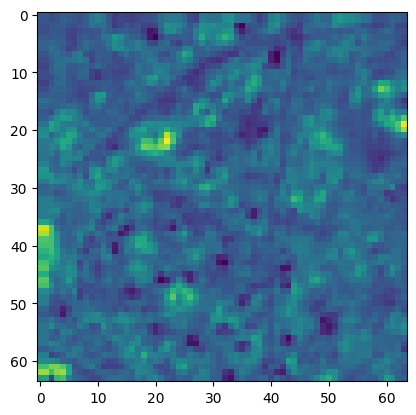

In [ ]:
# Function returns the raster data from the specified band of the GeoTIFF file.
def preprocess_geotiff(filepath):
    with rasterio.open(filepath) as src:
        # For example, read the eighth band:
        raster_data = src.read(8)
    return raster_data

image = preprocess_geotiff(path)
# Displaying the raster in an image format
plt.imshow(image)

**Putting all the 13 bands into a single dataframe for machine learning**

In [ ]:
# Define the bands
bands = ['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9', 'band10', 'band11', 'band12', 'band13']

# Initialize lists to store data
data = {band: [] for band in bands}
data['target'] = []

# Iterate through each class folder
class_folders = os.listdir(data_folder)
for class_folder in class_folders:
    class_path = os.path.join(data_folder, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        # Iterate through .tif files in the class folder
        tif_files = glob.glob(os.path.join(class_path, '*.tif'))
        for tif_file in tqdm(tif_files, desc=class_label):
        #for tif_file in tif_files:
            # Open the .tif file
            with rasterio.open(tif_file) as src:
                # Read image bands
                for i in range(1, src.count + 1):  # Iterate through bands
                    band_data = src.read(i)
                    data[f'band{i}'].append(band_data.ravel())
                # Append classification label
                data['target'].append(class_label)

# Create DataFrame
df = pd.DataFrame(data)

# Optional: Save DataFrame to a CSV file
#df.to_csv('EuroSAT_MS_dataset.csv', index=False)


River: 100%|██████████| 2500/2500 [00:18<00:00, 136.98it/s]


In [ ]:
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,band13,target
0,"[1382, 1382, 1383, 1387, 1396, 1410, 1429, 145...","[1217, 1217, 1196, 1196, 1137, 1210, 1346, 129...","[1293, 1293, 1220, 1204, 1170, 1239, 1465, 126...","[1482, 1482, 1385, 1375, 1406, 1490, 1707, 161...","[1550, 1550, 1542, 1533, 1554, 1602, 1649, 168...","[2066, 2066, 2099, 2170, 2234, 2266, 2261, 223...","[2402, 2402, 2437, 2496, 2545, 2565, 2553, 251...","[2451, 2451, 2512, 2579, 2363, 2472, 2586, 224...","[778, 778, 779, 782, 787, 792, 798, 805, 812, ...","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[2675, 2675, 2609, 2544, 2511, 2518, 2544, 258...","[1753, 1753, 1723, 1697, 1707, 1751, 1796, 183...","[2640, 2640, 2674, 2686, 2714, 2748, 2731, 266...",PermanentCrop
1,"[1459, 1459, 1449, 1442, 1437, 1436, 1436, 143...","[1243, 1243, 1266, 1284, 1298, 1251, 1224, 121...","[1365, 1365, 1385, 1456, 1466, 1409, 1352, 136...","[1539, 1539, 1622, 1738, 1770, 1689, 1638, 162...","[1791, 1791, 1836, 1889, 1924, 1916, 1876, 184...","[2376, 2376, 2405, 2437, 2441, 2410, 2362, 233...","[2749, 2749, 2757, 2764, 2752, 2719, 2683, 267...","[2594, 2594, 2576, 2668, 2720, 2620, 2513, 252...","[775, 775, 768, 763, 759, 757, 756, 756, 756, ...","[15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 1...","[3204, 3204, 3243, 3284, 3310, 3313, 3299, 328...","[2292, 2292, 2327, 2362, 2382, 2377, 2354, 233...","[3006, 3006, 3006, 3026, 3037, 3012, 2960, 292...",PermanentCrop
2,"[1296, 1296, 1297, 1298, 1299, 1299, 1300, 130...","[1191, 1191, 1192, 1187, 1209, 1212, 1169, 118...","[1308, 1308, 1357, 1363, 1377, 1368, 1285, 130...","[1961, 1961, 2026, 2065, 2069, 2008, 1821, 191...","[2148, 2148, 2176, 2187, 2177, 2157, 2140, 214...","[2436, 2436, 2453, 2458, 2451, 2445, 2448, 246...","[2679, 2679, 2689, 2690, 2681, 2679, 2689, 271...","[2573, 2573, 2603, 2605, 2676, 2668, 2767, 272...","[1110, 1110, 1112, 1115, 1118, 1122, 1125, 112...","[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 1...","[3792, 3792, 3826, 3841, 3836, 3815, 3799, 381...","[2712, 2712, 2743, 2759, 2759, 2738, 2714, 273...","[2836, 2836, 2856, 2865, 2861, 2863, 2875, 288...",PermanentCrop
3,"[1169, 1169, 1165, 1163, 1160, 1159, 1157, 115...","[964, 964, 962, 953, 953, 944, 923, 922, 918, ...","[945, 945, 948, 953, 946, 916, 912, 913, 922, ...","[831, 831, 806, 781, 792, 787, 768, 738, 718, ...","[1155, 1155, 1155, 1161, 1171, 1183, 1194, 120...","[1991, 1991, 2050, 2126, 2203, 2269, 2316, 235...","[2279, 2279, 2361, 2463, 2559, 2634, 2689, 273...","[2257, 2257, 2427, 2484, 2442, 2458, 2428, 253...","[752, 752, 757, 762, 768, 775, 781, 787, 793, ...","[12, 12, 12, 12, 12, 11, 11, 11, 11, 10, 10, 1...","[2251, 2251, 2230, 2201, 2166, 2125, 2079, 203...","[1575, 1575, 1530, 1479, 1423, 1363, 1306, 125...","[2510, 2510, 2581, 2664, 2752, 2838, 2915, 298...",PermanentCrop
4,"[1187, 1187, 1190, 1193, 1197, 1201, 1206, 121...","[986, 986, 964, 966, 950, 944, 974, 1019, 1000...","[987, 987, 1013, 959, 926, 934, 967, 1010, 991...","[973, 973, 948, 888, 818, 814, 888, 1012, 950,...","[1320, 1320, 1292, 1255, 1233, 1238, 1261, 129...","[2200, 2200, 2193, 2212, 2224, 2217, 2206, 222...","[2585, 2585, 2597, 2634, 2647, 2631, 2622, 265...","[2348, 2348, 2595, 2578, 2555, 2538, 2543, 240...","[583, 583, 585, 587, 590, 593, 596, 599, 602, ...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...","[2332, 2332, 2330, 2328, 2327, 2330, 2340, 235...","[1517, 1517, 1496, 1467, 1460, 1480, 1509, 152...","[2867, 2867, 2886, 2924, 2934, 2912, 2900, 293...",PermanentCrop


In [ ]:
df.shape

(27000, 14)

In [ ]:
df.columns

Index(['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8',
       'band9', 'band10', 'band11', 'band12', 'band13', 'target'],
      dtype='object')

In [ ]:
df['target'].unique()

array(['Industrial', 'Highway', 'AnnualCrop', 'SeaLake', 'River',
       'Forest', 'HerbaceousVegetation', 'Pasture', 'Residential',
       'PermanentCrop'], dtype=object)

In [ ]:
# Define the target column
target_column = df['target']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target column
encoded_target = label_encoder.fit_transform(target_column)

# Replace the original target column with the encoded values
df['target'] = encoded_target

# Display the mapping between original target values and their encoded representations
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping of original target values to encoded representations:")
print(mapping)

# Split the data into features (X) and target (y)
X = np.array(df.drop('target', axis=1))  # Assuming 'target' is the column to predict
y = df['target']
#X = np.array([np.concatenate(sample) for sample in X])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten the nested arrays in X_train
X_train_flat = np.array([np.concatenate(sample) for sample in X_train])

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Train the classifier on the training data
rf_classifier.fit(X_train_flat, y_train)


Mapping of original target values to encoded representations:
{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


RandomForestClassifier()

In [ ]:
X_test_flat = np.array([np.concatenate(sample) for sample in X_test])

In [ ]:
y_pred = rf_classifier.predict(X_test_flat)

In [ ]:
rf_classifier.score(X_train_flat, y_train)

1.0

In [ ]:
rf_classifier.score(X_test_flat, y_test)

0.8203703703703704

In [ ]:
from joblib import dump

# Save the trained model to a file
model_filename = 'random_forest_model.joblib'
dump(rf_classifier, model_filename)


['random_forest_model.joblib']

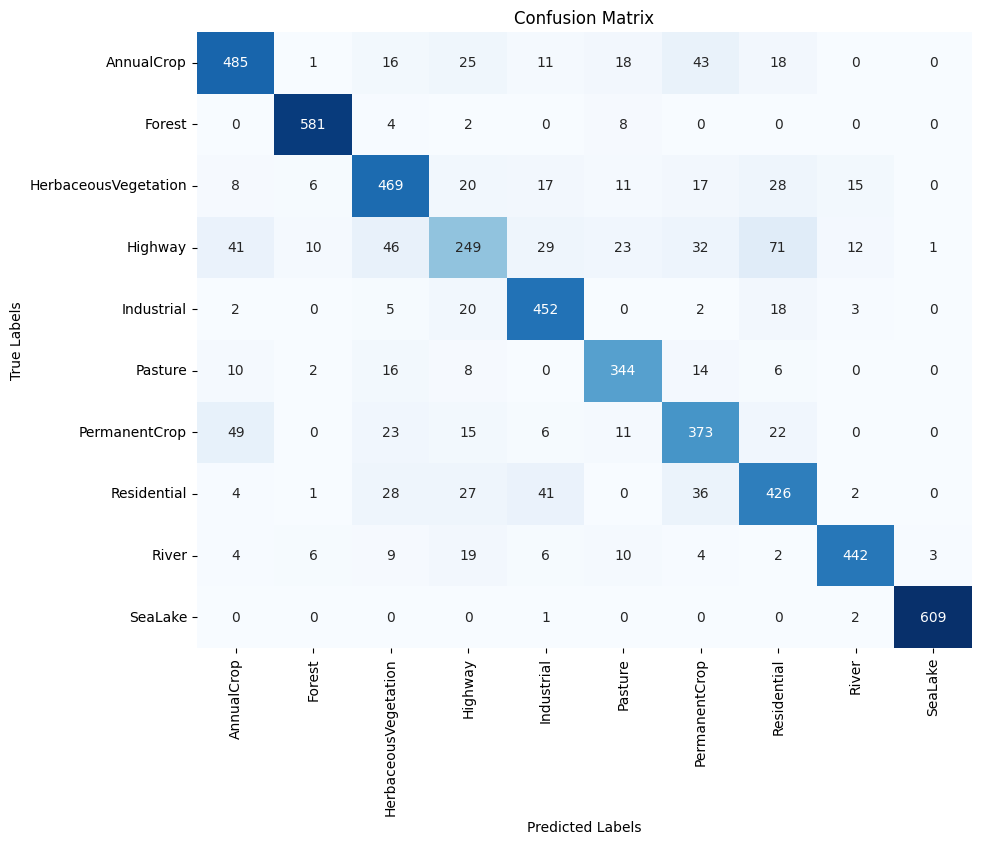

In [ ]:
# Define class labels
class_labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
                'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import joblib

In [ ]:
model_path ="/content/drive/MyDrive/random_forest_model (1).joblib"
# Load the saved model
loaded_model = joblib.load(model_path)

In [ ]:
# Define the bands
bands = ['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9', 'band10', 'band11', 'band12', 'band13']
mapping = {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
# Initialize lists to store data
data = {band: [] for band in bands}
#data['target'] = []
path = "/content/Datasets/EuroSAT_MS/Residential/Residential_1146.tif"
def predictor(path):
  with rasterio.open(path) as src:
      # Read image bands
      for i in range(1, src.count + 1):  # Iterate through bands
          band_data = src.read(i)
          data[f'band{i}'].append(band_data.ravel())
      # Append classification label
      #data['target'].append(class_label)
      df = pd.DataFrame(data)
  X = np.array(df)
  X_flat = np.array([np.concatenate(sample) for sample in X])
  prediction = loaded_model.predict(X_flat)
  predicted_class = list(mapping.keys())[list(mapping.values()).index(prediction[0])]
  return predicted_class


In [ ]:
land_cover = predictor(path)
land_cover

'Residential'